In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os 
import math
np.random.seed(1234)

In [34]:
def sigmoid(x):
    return 1/(1+np.exp(-x+0.5))

def psigmoid(x):
    a = sigmoid(x)
    return a*(1 - a)

def ppsigmoid(x):
    a = sigmoid(x)
    return a - 3*a**2 + 2*a**3

def LeapFct(X,sets,coefs):
    p_sets = len(sets)
    parities = np.zeros((X.shape[0],p_sets))
    for j in range(p_sets):
        curr = np.ones(X.shape[0])
        for s in range(len(sets[j])):
            curr = curr*X[:,sets[j][s]]
        parities[:,j] = curr*coefs[j]
    return np.sum(parities,axis = 1)/ p_sets

def SquaredLoss(ytest,yhat_test):
    return np.mean((ytest - yhat_test)**2)

def randomRademacher(n,d):
    return 2*np.random.randint(2, size=(n,d))-1

def randomSecondLayer(N):
    return np.random.uniform(-1,1,N)

In [35]:
def smooth(v,ll):
    if ll == 0:
        return v
    ss = len(v)
    rr = np.copy(v)
    for i in range(ss):
        rr[i] = np.mean(v[max(0,i -ll):min(ss,i+ll)])
    return rr

In [36]:
def loss_train(y,f):
    return (y - f)**2 + (y - f)**3 +(y-f)**4

def loss_derivative(y,f):
    return 2*(y - f) + 3*(y - f)**2 + 4*(y-f)**3

def loss1_train(y,f):
    return (y - f)**2 + np.abs(y - f)**3 

def loss1_derivative(y,f):
    return 2*(y - f) + 3*np.sign(y-f)*(y - f)**2 

def squared_loss(y,f):
    return (y-f)**2

def squared_loss_derivative(y,f):
  return 2*(y-f)

def loss_ellone(y,f):
    return np.abs(y-f)

def loss_ellone_derivative(y,f):
    return np.sign(y-f)

In [37]:
def NNevaluation(W,a,X,N):
    Z = np.matmul(X,W.transpose())
    sigZ = sigmoid(Z)
    return np.matmul(sigZ,a)/N

def EvalError(W,a,mtest,N,P,d,sets,coefs):
    Xtest = randomRademacher(mtest,d)
    ytest = LeapFct(Xtest,sets,coefs)
    yhat_test = NNevaluation(W,a,Xtest,N)
    return SquaredLoss(ytest,yhat_test)

def gradient_sq_loss(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*squared_loss_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, squared_loss_derivative(ytrain,yMF))/mtrain]

def gradient_ellone_loss(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*loss_ellone_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, loss_ellone_derivative(ytrain,yMF))/mtrain]

def gradient_loss1(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*loss1_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, loss1_derivative(ytrain,yMF))/mtrain]


def evaluateFourierCoeff(W,a,N,mtest,P,d,sets,coefs):
    Xtest = randomRademacher(mtest,d)
    yMF = NNevaluation(W,a,Xtest,N)
    p_sets = len(sets)
    parities = np.zeros((mtest,p_sets))
    for j in range(p_sets):
        curr = np.ones(mtest)
        for s in range(len(sets[j])):
            curr = curr*Xtest[:,sets[j][s]]
        parities[:,j] = curr/coefs[j]
    return np.matmul(parities.transpose(),yMF)/mtest

In [38]:
def createXtot(P):
    Xtot = np.zeros((2**P,P))
    for i in range(2**P):
        Xtot[i,:] = np.array(list(np.binary_repr(i, width=P)))
    return 2*Xtot-1

In [39]:
def pexMSPEvalError(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    ytest = LeapFct(Xtot,sets,coefs)
    yhat_test = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return SquaredLoss(ytest,yhat_test)

def pexMSPNNevaluation(U,a,s,Xtot,mx,Nu,mG):
    G = np.random.normal(0,1,mG)
    Z = np.matmul(Xtot,U.transpose()).reshape(mx,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((mx,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2)
    return np.matmul(sigZ,a)/Nu

def pexMSPgradientloss(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss_derivative(ytrain,yMF))/2**P]

def pexMSPgradientsqloss(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*squared_loss_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,squared_loss_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, squared_loss_derivative(ytrain,yMF))/2**P]

def pexMSPgradientloss1(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss1_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss1_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss1_derivative(ytrain,yMF))/2**P]

def pexMSPgradientlossellone(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss_ellone_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss_ellone_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss_ellone_derivative(ytrain,yMF))/2**P]

def pexMSPevaluateFourierCoeff(U,a,s,Xtot,mG,Nu,P,sets,coefs):
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    p_sets = len(sets)
    parities = np.zeros((2**P,p_sets))
    for j in range(p_sets):
        curr = np.ones(2**P)
        for s in range(len(sets[j])):
            curr = curr*Xtot[:,sets[j][s]]
        parities[:,j] = curr/coefs[j]
    return np.matmul(parities.transpose(),yMF)/2**P

In [40]:
P = 4
uuu = [[1,2,3],[0,2,3],[0,1,3],[0,1,2]]
ccc=np.random.uniform(-2,2,len(uuu))
print(ccc)
mmm = len(uuu)
KK=10
T=4000

[-1.2339222   0.48843508 -0.24908904  1.14143433]


In [41]:
d = 100
xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF11 = np.zeros((KK,T))

TrackLossSGD11 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD11[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_loss1(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF11[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        [GUDF,GaDF,GsDF] = pexMSPgradientloss1(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        if t%500==0:
         print(kk,t, TrackLossDF11[kk,t], TrackLossSGD11[kk,t])

0 0 0.19541712235657352 0.20766236877122027
0 500 0.0008149703559747494 0.0028234518824595827
0 1000 4.220944912279885e-05 6.689563365822315e-06
0 1500 3.962433515200612e-06 3.862999129508808e-06
0 2000 8.185035010096837e-06 2.4120263575689297e-06
0 2500 9.17547107953509e-06 2.2841025091015067e-06
0 3000 1.5192243055544034e-05 2.022271209695521e-06
0 3500 2.3742590890305985e-05 2.1514014707461423e-06
1 0 0.19558689742954233 0.1848392068607833
1 500 0.0007345022945905881 0.0006302234043273959
1 1000 3.505111481543474e-05 7.220815916992793e-06
1 1500 3.7736612776725048e-06 5.170715240543426e-06
1 2000 5.564550617492231e-06 3.895947319062445e-06
1 2500 1.1199393750161888e-05 3.50885605550457e-06
1 3000 1.124835050699864e-06 3.313890483837382e-06
1 3500 2.776290673087018e-05 2.5943319969924443e-06
2 0 0.20341352358004894 0.20600593359282632
2 500 0.0009433693540054436 0.002570251876071437
2 1000 5.390071820382647e-05 5.362134724101817e-06
2 1500 8.630106605918714e-06 3.5045890672327195e-06

In [42]:
d =300

xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF12 = np.zeros((KK,T))
TrackLossSGD12 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD12[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_loss1(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF12[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        [GUDF,GaDF,GsDF] = pexMSPgradientloss1(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        if t%500 ==0:
         print(kk,t,TrackLossDF12[kk,t], TrackLossSGD12[kk,t])

0 0 0.19610037455539842 0.18807461254809643
0 500 0.0005378632784226391 0.008374423238411395
0 1000 5.929361869553429e-05 1.1786686079720615e-05
0 1500 5.6918447645989625e-05 5.814107209565626e-06
0 2000 3.8875007975139154e-05 4.352680128523027e-06
0 2500 3.0098793061056284e-05 4.498441284595032e-06
0 3000 7.921638208610979e-06 4.1798620895421015e-06
0 3500 2.9162659242261864e-05 3.6458618578564186e-06
1 0 0.19697996074235438 0.18192389195552008
1 500 0.0016513852223151465 0.005404869012221495
1 1000 2.7622860203236123e-05 3.5677091632554786e-05
1 1500 3.389428143892524e-06 7.603151355927882e-06
1 2000 1.0996421873619116e-06 4.049458309270747e-06
1 2500 6.543247473510744e-06 3.3677901499663214e-06
1 3000 1.5748268916252695e-05 3.77250717176826e-06
1 3500 2.2961239112271352e-06 2.8779493139724786e-06
2 0 0.19543525452401522 0.21932301051939437
2 500 0.0005614183989822054 0.006398163129673892
2 1000 2.979815999391114e-06 4.058186352104802e-05
2 1500 4.75116268332202e-06 1.100652062830295

In [43]:
d = 500

xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF13 = np.zeros((KK,T))

TrackLossSGD13 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD13[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_loss1(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF13[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        
        [GUDF,GaDF,GsDF] = pexMSPgradientloss1(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        if t%500==0:
         print(kk,t,TrackLossDF13[kk,t], TrackLossSGD13[kk,t])

0 0 0.19542639898699823 0.19016771472302318
0 500 0.0011579201717097603 0.008149673285291476
0 1000 3.449330769843262e-05 7.662329998501255e-06
0 1500 2.0728831719425203e-05 5.7313139648450135e-06
0 2000 4.200603643685709e-06 4.5551438999575e-06
0 2500 6.453643029884181e-06 4.234385455989914e-06
0 3000 1.8045889186092023e-06 4.211060534597621e-06
0 3500 5.7816448485193615e-06 3.860143082565762e-06
1 0 0.195418452471446 0.191881215881193
1 500 0.0010931003721337544 0.005014388054078664
1 1000 8.843510454604244e-05 9.56315529555043e-06
1 1500 4.387707609157891e-05 5.849747235356739e-06
1 2000 4.042687957857889e-05 5.661998847610075e-06
1 2500 0.00014044434171534427 4.394263968616587e-06
1 3000 6.181366608359651e-05 3.819083467387576e-06
1 3500 0.00010706540884176661 4.1015469708201426e-06
2 0 0.19581501312051558 0.20003248883096728
2 500 0.0010245407392218753 0.0035092389306139314
2 1000 6.703709607658728e-05 7.404188514769643e-06
2 1500 6.684912014579391e-06 5.427239488549449e-06
2 2000

In [44]:
meanLossDF11 =  np.mean(TrackLossDF11,axis = 0)

meanLoss11 = np.mean(TrackLossSGD11,axis = 0)
stdLoss11 = np.std(TrackLossSGD11,axis = 0)/np.sqrt(KK)


In [45]:
meanLossDF12 =  np.mean(TrackLossDF12,axis = 0)

meanLoss12 = np.mean(TrackLossSGD12,axis = 0)
stdLoss12 = np.std(TrackLossSGD12,axis = 0)/np.sqrt(KK)


In [46]:
meanLossDF13 = np.mean(TrackLossDF13,axis = 0)

meanLoss13 = np.mean(TrackLossSGD13,axis = 0)
stdLoss13 = np.std(TrackLossSGD13,axis = 0)/np.sqrt(KK)

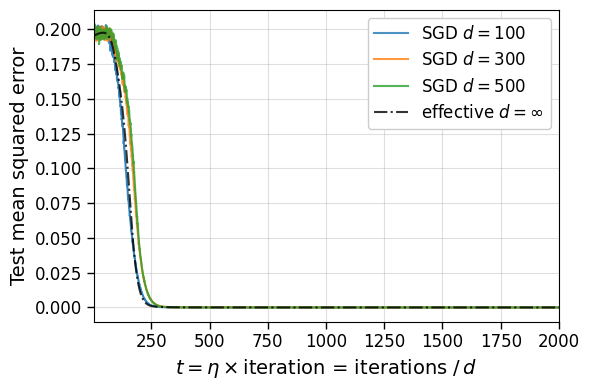

In [47]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))#, gridspec_kw={'width_ratios': [1.5, 2]})


ax.plot(xi*np.arange(T),smooth(meanLoss11,1), linestyle='-', alpha = 0.8, label=r'SGD $d=100$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss11 - stdLoss11,4), smooth(meanLoss11 + stdLoss11,4),  alpha = 0.6)

ax.plot(xi*np.arange(T),smooth(meanLoss12,1), linestyle='-', alpha = 0.8, label=r'SGD $d=300$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss12 - stdLoss12,4), smooth(meanLoss12 + stdLoss12,4),  alpha = 0.6)


ax.plot(xi*np.arange(T),smooth(meanLoss13,1), linestyle='-', alpha = 0.8, label=r'SGD $d=500$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss13 - stdLoss13,4), smooth(meanLoss13 + stdLoss13,4),  alpha = 0.6)


   
ax.plot(xi*np.arange(T),smooth(meanLossDF11,5), color ='black', alpha = 0.8,linestyle='-.', label='effective $d=\infty$')

ax.grid(alpha=0.4)
ax.set_xlabel(r'$t= \eta \times $iteration = iterations $/\,d$', fontsize =14)
ax.set_ylabel(r'Test mean squared error', fontsize =14)
plt.setp(ax.get_xticklabels(),fontsize=12)
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.tick_params(direction='out', length=5, width=1)
ax.legend(loc='upper right', fontsize=12, framealpha = 1)
ax.set_xlim([3,xi*T])

fig.tight_layout()
plt.savefig('ell3loss/ell3leap1.pdf')
plt.show()

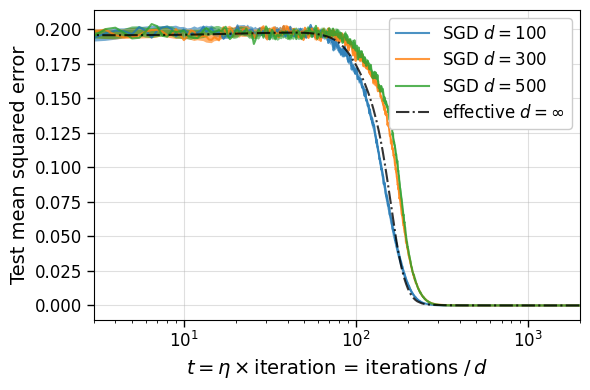

In [48]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))#, gridspec_kw={'width_ratios': [1.5, 2]})


ax.plot(xi*np.arange(T),smooth(meanLoss11,1), linestyle='-', alpha = 0.8, label=r'SGD $d=100$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss11 - stdLoss11,4), smooth(meanLoss11 + stdLoss11,4),  alpha = 0.6)

ax.plot(xi*np.arange(T),smooth(meanLoss12,1), linestyle='-', alpha = 0.8, label=r'SGD $d=300$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss12 - stdLoss12,4), smooth(meanLoss12 + stdLoss12,4),  alpha = 0.6)


ax.plot(xi*np.arange(T),smooth(meanLoss13,1), linestyle='-', alpha = 0.8, label=r'SGD $d=500$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss13 - stdLoss13,4), smooth(meanLoss13 + stdLoss13,4),  alpha = 0.6)


   
ax.plot(xi*np.arange(T),smooth(meanLossDF11,5), color ='black', alpha = 0.8,linestyle='-.', label='effective $d=\infty$')

ax.grid(alpha=0.4)
ax.set_xlabel(r'$t= \eta \times $iteration = iterations $/\,d$', fontsize =14)
ax.set_ylabel(r'Test mean squared error', fontsize =14)
plt.setp(ax.get_xticklabels(),fontsize=12)
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.tick_params(direction='out', length=5, width=1)
ax.legend(loc='upper right', fontsize=12, framealpha = 1)
ax.set_xscale('log')
ax.set_xlim([3,xi*T])

fig.tight_layout()
plt.savefig('ell3loss/ell3leap1-log.pdf')
plt.show()